<a href="https://colab.research.google.com/github/isoittech/udemy-Hands-on-PyTorch/blob/main/07_%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.en = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.de = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # もとの次元に戻す

            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # もとの次元に戻す

            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
            nn.Tanh() # ReLUを使うよりも損失が下がる傾向があるので、ハイパボリックタンジェントを使う
        )
    
    def forward(self, x):
        x = self.en(x)
        x = self.de(x) # 再構成されたxを算出
        return x

In [13]:
model = ConvAE()
model.to(device)

ConvAE(
  (en): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (de): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, imgs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    losses.append(running_loss)
    print("epoch: {}, loss: {}".format(epoch, running_loss))

epoch: 0, loss: 0.09493385207653046
epoch: 1, loss: 0.09493459303776423
epoch: 2, loss: 0.09493384131590525
epoch: 3, loss: 0.09493429200251897
epoch: 4, loss: 0.09493384370803833
epoch: 5, loss: 0.09493383543093999
epoch: 6, loss: 0.09493391951719919
epoch: 7, loss: 0.09493421637614569
epoch: 8, loss: 0.09493314030170441
epoch: 9, loss: 0.0949348636786143
epoch: 10, loss: 0.0949342399319013
epoch: 11, loss: 0.09493380275567373
epoch: 12, loss: 0.0949346896370252
epoch: 13, loss: 0.09493436585267385
epoch: 14, loss: 0.09493382751941681


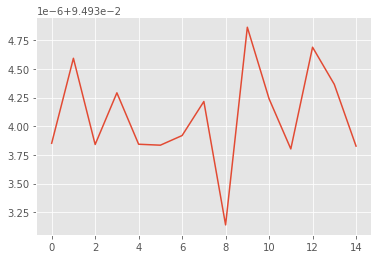

In [28]:
plt.style.use("ggplot")
plt.plot(losses)

In [29]:
data_iter = iter(train_loader)

In [30]:
imgs, _ = data_iter.next()

In [31]:
img = imgs[0]

In [32]:
img_permute = img.permute(1, 2, 0)

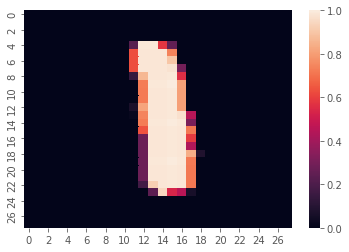

In [33]:
sns.heatmap(img_permute[:, :, 0])

In [34]:
x_en = model.en(imgs.to(device))

In [35]:
x_en2 = x_en[0].permute(1, 2, 0) # channel lastにしとく

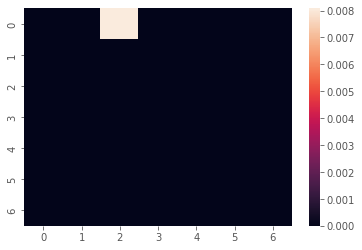

In [36]:
sns.heatmap(x_en2[:, :, 0].detach().to("cpu")) # 勾配計算を切り離すdetachが必要

In [37]:
x_ae = model(imgs.to(device))

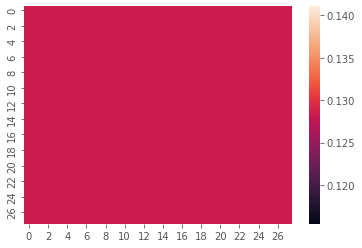

In [38]:
sns.heatmap(x_ae[0].permute(1, 2, 0).detach().to("cpu")[:, :, 0])

うまくいかない。
うまく行けば、「１」っぽいものが出るはず。